# Principal Component Analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline

# Learning Goals

- Explain the concepts behind principal component analysis (PCA)
- Explain how PCA addresses the problem of multicollinearity
- Explain the idea of eigendecomposition
- Implement PCA using `sklearn`

# Motivation

So far, you have dealt with datasets with a moderate number of predictors. What would happen if you had thousands of predictors? A few problems can arise:

* Requires a ton of computing power/time
* Computational problems caused by multicollinearity
* Can overfit your data

How could we address this problem?

* You could drop a bunch of predictors at random, but you would potentially lose useful information that way 
* You could drop predictors that have weak correlations with your target, but they may still be useful in combination with other features in non-linear models (e.g. interaction terms, decision trees) 
* You could combine a bunch of features together, such as by multiplying them, but it's not clear how you would do this to best preseve information

Principal Component Analysis (PCA) is a tool for reducing the dimensionality of our data in a way that tries to preserve information. It does this by projecting our data from a higher-dimensional space onto a lower-dimensional space. The PCA algorithm chooses a lower-dimensional space to project to that will preserve as much variance as possible from our original dataset.

# Scenario: Shipping Costs

Let's say that we want to predict the cost to ship a package based on its properties. 

In [2]:
packages = pd.read_csv('data/packages.csv')
packages.head(10)

,Shipping Cost ($),Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
0,24,36,32,9,18,1079
1,38,41,31,12,18,1797
2,38,34,34,15,24,1722
3,20,32,22,8,8,461
4,24,37,24,14,19,491
5,21,32,20,3,6,1029
6,27,33,23,7,11,945
7,31,40,31,16,22,1649
8,30,37,28,12,20,1310
9,26,29,29,11,11,161


## Dimensionality

You can think about each variable as a dimension, and thus each package as a data point. If we take just one feature, we can easily visualize this in 2 dimensional space

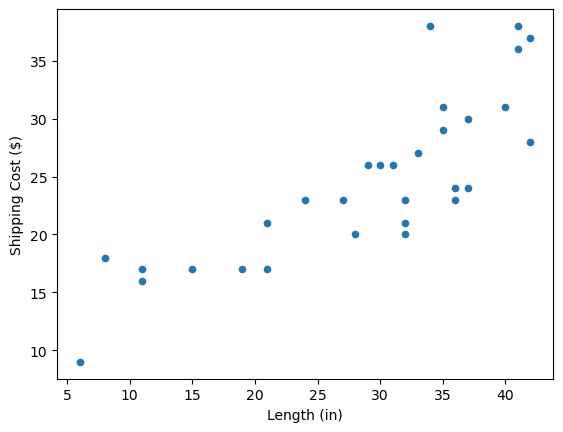

In [3]:
packages.plot(kind='scatter', y='Shipping Cost ($)', x='Length (in)');

You can think of each package as a point in six-dimensional space - 5 dimensions for our features and 1 for our target.

## Correlation and Covariance Matrices

The first four features in this dataset all relate to package size, so we might expect them to be strongly related.

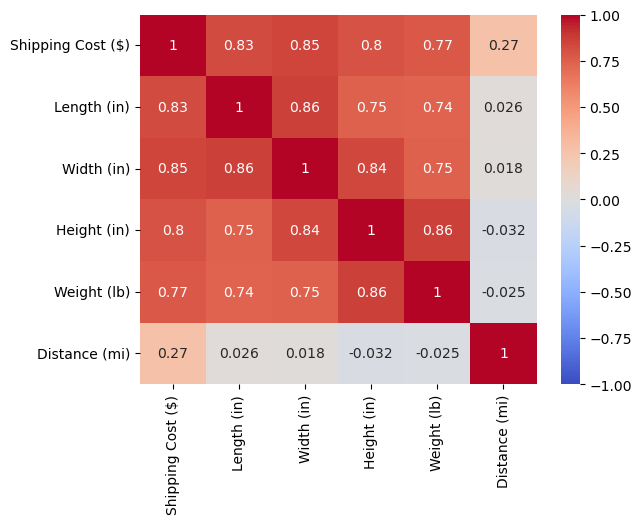

In [4]:
sns.heatmap(packages.corr(),
            annot=True,
            fmt='0.2g',
            vmin=-1,
            vmax=1,
            center=0,
            cmap='coolwarm');

PCA does not use this **correlation matrix**, which is conveniently scaled between -1 and 1. Rather, it uses the **covariance matrix**, which is scaled in square units of the original variables. This makes PCA very sensitive to the scale of the variables.

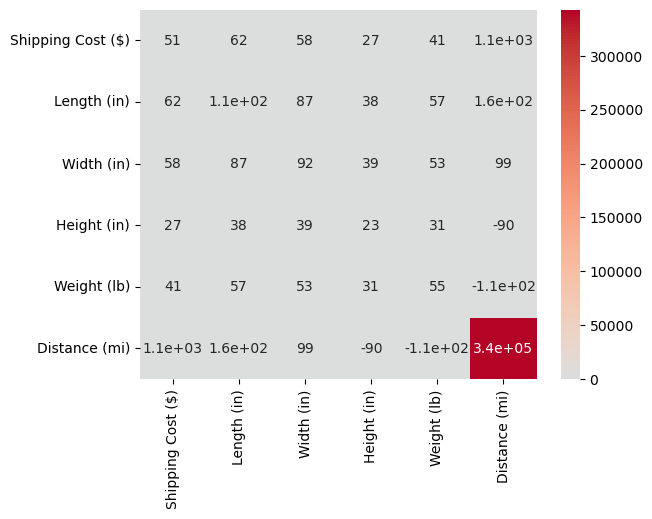

In [5]:
sns.heatmap(packages.cov(),
            annot=True,
            fmt='0.2g',
            center=0,
            cmap='coolwarm');

Let's normalize our variables to mean = 0 & SD = 1, which will make our covariance matrix equal the correlation matrix.

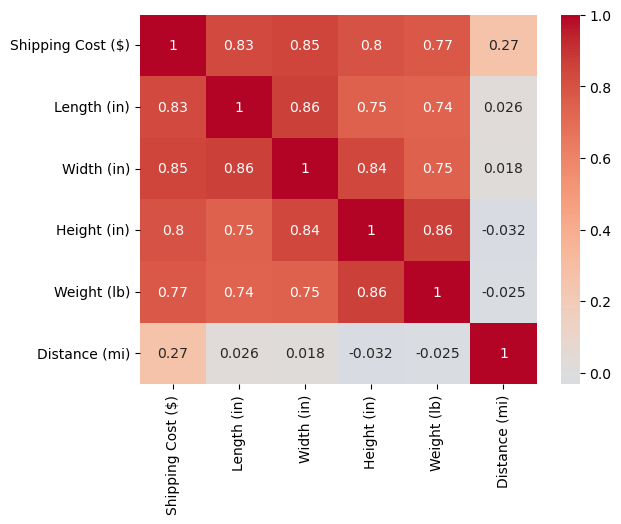

In [6]:
packages_scaled = (packages - packages.mean())/packages.std()
sns.heatmap(packages_scaled.cov(),
            annot=True,
            fmt='0.2g',
            center=0,
            cmap='coolwarm');

Notice that, for the centered data matrix $X$, the covariance matrix $C$ is equal to $\frac{1}{n-1}X^TX$:

In [7]:
packages_scaled.cov()

,Shipping Cost ($),Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
Shipping Cost ($),1.000000,0.826989,0.849963,0.800307,0.774526,0.266277
Length (in),0.826989,1.000000,0.862847,0.746525,0.738311,0.026250
Width (in),0.849963,0.862847,1.000000,0.837949,0.747395,0.017698
Height (in),0.800307,0.746525,0.837949,1.000000,0.861819,-0.032043
Weight (lb),0.774526,0.738311,0.747395,0.861819,1.000000,-0.024568
Distance (mi),0.266277,0.026250,0.017698,-0.032043,-0.024568,1.000000


In [8]:
packages_scaled.T.dot(packages_scaled) / (len(packages_scaled)-1)

,Shipping Cost ($),Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
Shipping Cost ($),1.000000,0.826989,0.849963,0.800307,0.774526,0.266277
Length (in),0.826989,1.000000,0.862847,0.746525,0.738311,0.026250
Width (in),0.849963,0.862847,1.000000,0.837949,0.747395,0.017698
Height (in),0.800307,0.746525,0.837949,1.000000,0.861819,-0.032043
Weight (lb),0.774526,0.738311,0.747395,0.861819,1.000000,-0.024568
Distance (mi),0.266277,0.026250,0.017698,-0.032043,-0.024568,1.000000


That means that the covariance matrix preserves the information about the spread of our dataset. What we want to do now is to explain that spread, one linear transformation (one **eigenvector**) at a time. For more see [this useful blog post](https://datascienceplus.com/understanding-the-covariance-matrix/).

Let's try to reduce the dimensionality of our dataset. Since the features capturing size are strongly correlated, we might expect to be able to reduce our feature dimensions down to two without losing much information (i.e. variance in our features).

## Eigendecomposition

We will use an **eigendecomposition** of the covariance matrix to create a new set of dimensions. We can then decide how many of these dimensions to keep based on how much variance is captured by each dimension.

Here, we show you how to do this using the NumPy `.eig()` function, but we will learn how to do PCA more easily in `sklearn` later.

In [9]:
y_packages_scaled = packages_scaled['Shipping Cost ($)']
X_packages_scaled = packages_scaled.drop('Shipping Cost ($)', axis=1)

cov_mat = X_packages_scaled.cov().values
eigvals, eigvecs = np.linalg.eig(cov_mat)

In [71]:
cov_mat

array([[ 1.        ,  0.86284654,  0.74652451,  0.73831054,  0.02624986],
       [ 0.86284654,  1.        ,  0.83794881,  0.74739527,  0.01769847],
       [ 0.74652451,  0.83794881,  1.        ,  0.86181886, -0.03204252],
       [ 0.73831054,  0.74739527,  0.86181886,  1.        , -0.02456763],
       [ 0.02624986,  0.01769847, -0.03204252, -0.02456763,  1.        ]])

In [72]:
eigvecs

array([[-0.49219397, -0.04575099,  0.58937372,  0.39011986,  0.50606033],
       [-0.50780159, -0.03152634,  0.38635373, -0.59429315, -0.48855918],
       [-0.5075545 ,  0.03825687, -0.38501594,  0.58895092, -0.49580679],
       [-0.49220305,  0.03337828, -0.59133959, -0.38424744,  0.50920864],
       [ 0.00268878, -0.9971636 , -0.07382155,  0.01062355, -0.00974944]])

In [73]:
eigvals

array([3.39821068, 1.00381562, 0.3338863 , 0.08609481, 0.17799259])

This decomposition gives us two things: eigenvalues and eigenvectors.

## Eigenvalues

**Eigenvalues** represent the relative amount of variance captured by each new dimension. The average eigenvalue will be 1, so we look for values over 1 to identify dimensions that capture more variance than average. 

In [10]:
eigvals

array([3.39821068, 1.00381562, 0.3338863 , 0.08609481, 0.17799259])

It looks like we have one great dimension capturing 3.4x more variance than average, one OK dimension capturing an average amount of variance, and three other dimensions that don't capture much variance. This is in line with what we were expecting! It means that we can just use the first two dimensions - and drop the last three - without losing much variance/information from our predictors.

### Proportion of Variance

You can also divide your eigenvalues by the number of features and then interpret them as the _proportion of variance in the features_ captured by each dimension.

In [11]:
eigvals/5

array([0.67964214, 0.20076312, 0.06677726, 0.01721896, 0.03559852])

## Eigenvectors (aka Principal Components)

**Eigenvectors** represent the new dimensions, which we call **principal components** when doing PCA. There is one eigenvector for each dimension, and they are all combined together into one matrix.

In [12]:
eigvecs

array([[-0.49219397, -0.04575099,  0.58937372,  0.39011986,  0.50606033],
       [-0.50780159, -0.03152634,  0.38635373, -0.59429315, -0.48855918],
       [-0.5075545 ,  0.03825687, -0.38501594,  0.58895092, -0.49580679],
       [-0.49220305,  0.03337828, -0.59133959, -0.38424744,  0.50920864],
       [ 0.00268878, -0.9971636 , -0.07382155,  0.01062355, -0.00974944]])

In PCA, the values in our eigenvectors are called **component weights**, and they tell us how much variance of each feature is captured by that dimension. These weights range from -1 to 1, but the relative sizes are what matter.

### Orthogonality

These eigenvectors are **orthogonal**, meaning their dot product is zero. Think of it like being at right angles, like the x and y axes of a graph, but in higher-dimensional space. 

In [13]:
eigvec1 = eigvecs[:, 0]
eigvec2 = eigvecs[:, 1]
eigvec1.dot(eigvec2)

2.581477333302632e-17

### First Principal Component

The first column of `eigvecs` is our first eigenvector, corresponding to the eigenvalue of 3.4. Let's look at it.

In [14]:
eigvec1

array([-0.49219397, -0.50780159, -0.5075545 , -0.49220305,  0.00268878])

Notice that the first four numbers are relatively large, while the fifth is near zero. This means that this first dimension is almost entirely capturing the shared variance in our four size features, as we hoped! It's also interesting to note that the weights for the four features are almost equal, so they are equally represented in this dimension.

### Second Principal Component

Let's look at our second eigenvector and see what features it seems to be capturing.

In [15]:
eigvec2

array([-0.04575099, -0.03152634,  0.03825687,  0.03337828, -0.9971636 ])

Looks like it is almost entirely capturing the distance dimension, which makes sense, since that is not related to the package size at all. It has an eigenvalue of 1, which is appropriate, since the eigenvector only captures one feature, which wasn't captured at all in the first principal component.

### Remaining Principal Components

Since the remaining eigenvalues were all much less than 1, we can ignore the eigenvectors associated with them. We will not include components corresponding to them in our model.

## Sidebar: Properties of Eigenvectors

These eigenvectors have **unit length** (length 1) in multi-dimensional space.

In [16]:
np.linalg.norm(eigvec1)

0.9999999999999999

Eigenvectors are related to eigenvalues by the following property: $\vec{x}$ is an eigenvector of the matrix $A$ if $A\vec{x} = \lambda\vec{x}$, for some eigenvalue $\lambda$.

In [17]:
cov_mat.dot(eigvec1)

array([-1.67257881, -1.72561679, -1.72477713, -1.67260965,  0.00913704])

In [18]:
eigval1 = eigvals[0]
eigval1*eigvec1

array([-1.67257881, -1.72561679, -1.72477713, -1.67260965,  0.00913704])

## Transforming Data

We will now use these principal components to create new features. These features will be weighted sums (aka **linear combinations**) of existing features, using the component weights from the eigenvectors.

### First Component

We will now create a new feature using the first principal component. 

In [19]:
eigvec1

array([-0.49219397, -0.50780159, -0.5075545 , -0.49220305,  0.00268878])

Our first feature will be calculated as follows:

**PC1** = 0.492 * Length + 0.508 * Width + 0.508 * Height + 0.492 * Weight - 0.003 * Distance

We use a dot product between the data and the eigenvector to do the arithmetic for us.

In [20]:
data_array = X_packages_scaled.values
pc1 = data_array.dot(eigvec1)
X_packages_pca = pd.DataFrame(data=pc1, columns=['PC1'])
X_packages_pca.head()

,PC1
0,-1.192513
1,-1.688493
2,-2.234645
3,0.290959
4,-1.414106


### All Components

You can calculate all the new features at once using a dot product with the `eigvecs` matrix, which has all the eigenvectors in it.

In [21]:
pcs = data_array.dot(eigvecs)
X_packages_pca = pd.DataFrame(data=pcs, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
X_packages_pca.head(10)

,PC1,PC2,PC3,PC4,PC5
0,-1.192513,0.011650,0.407876,-0.588424,0.163901
1,-1.688493,-1.205932,0.317144,0.041075,0.133948
2,-2.234645,-1.006587,-0.664870,-0.348741,-0.253999
3,0.290959,1.061686,0.735155,0.266194,-0.092025
4,-1.414106,1.079541,-0.265270,0.496291,0.181112
5,1.061393,0.051879,1.143796,-0.110168,0.380225
6,0.100198,0.235135,0.611887,-0.027946,0.206453
7,-2.330934,-0.899571,-0.360289,0.285432,-0.051032
8,-1.476768,-0.340101,-0.126462,-0.034181,0.239101
9,-0.456826,1.600189,0.406495,-0.071489,-0.692824


## Feature Correlations

Because we used eigenvectors to construct our new features, we have completely solved any multicollinearity issues. This is because the eigenvectors define new, uncorrelated dimensions:

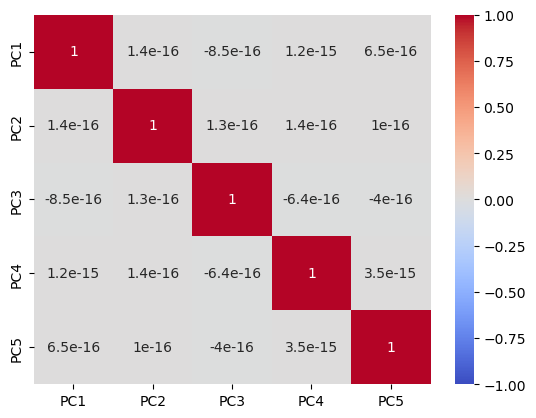

In [22]:
sns.heatmap(X_packages_pca.corr(),
            annot=True,
            fmt='0.2g',
            vmin=-1,
            vmax=1,
            center=0,
            cmap= 'coolwarm');

## Modeling

Now let's compare linear regression models with...

* All five original features 
* All five new features
* Only 2 best new features
* Only 1 best new feature

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_packages_scaled, y_packages_scaled)

**Model 1: All base features**:

In [24]:
sm1 = OLS(exog=X_train, endog=y_train).fit()
sm1.rsquared

0.8903924687265342

In [25]:
y_test_hat = sm1.predict(X_test)
mse(y_test, y_test_hat)

0.2877277886385001

**Model 2: All PCs**:

In [26]:
tr_eigval, tr_eigvec = np.linalg.eig(X_train.cov())

X_tr_pca = X_train.dot(tr_eigvec)

sm2 = OLS(exog=X_tr_pca, endog=y_train).fit()
sm2.rsquared

0.8903924687265342

In [27]:
y_test_hat2 = sm2.predict(X_test.dot(tr_eigvec))
mse(y_test, y_test_hat2)

0.28772778863850035

**Model 3 (Exercise!): Only PCs 1 and 2**:

In [77]:
sm3 = OLS(exog=X_tr_pca.loc[:, :2], endog=y_train).fit()


ValueError: The indices for endog and exog are not aligned

In [ ]:
smr.rsquared

In [ ]:
y_test_hat3 = sm3.predict(X_test.dot(tr_eigvec).loc[]:,:2])
mse

<details>
    <summary>Answer</summary>
<code>sm3 = OLS(exog=X_tr_pca.loc[:, :2], endog=y_train).fit()
print(sm3.rsquared)
y_test_hat3 = sm3.predict(X_test.dot(tr_eigvec).loc[:, :2])
mse(y_test, y_test_hat3)</code>

**Model 4 (Exercise!): Only PC 1**:

<details>
    <summary>Answer</summary>
<code>sm4 = OLS(exog=X_tr_pca.loc[:, 0], endog=y_train).fit()
print(sm4.rsquared)
y_test_hat4 = sm4.predict(X_test.dot(tr_eigvec).loc[:, 0])
mse(y_test, y_test_hat4)</code>

## PCA in `sklearn`

As always, `sklearn` makes this all much easier, this time with the `PCA()` class.

In [28]:
pca = PCA(n_components=2) # Check out how `n_components` works

X_packages_pca2 = pca.fit_transform(X_packages_scaled)

You can get the eigenvalues and eigenvectors out, too 

In [29]:
pca.explained_variance_

array([3.39821068, 1.00381562])

In [30]:
pca.explained_variance_ratio_

array([0.67964214, 0.20076312])

Sometimes the signs get flipped on the eigenvectors - don't worry about it. Think of "up" and "down" as both representing the same dimension, just in opposite directions.

In [31]:
pca.components_

array([[-0.49219397, -0.50780159, -0.5075545 , -0.49220305,  0.00268878],
       [-0.04575099, -0.03152634,  0.03825687,  0.03337828, -0.9971636 ]])

Then you can use your transformed data as you would in any model

In [32]:
lr_pca = LinearRegression()
lr_pca.fit(X_packages_pca2, y_packages_scaled)
lr_pca.score(X_packages_pca2, y_packages_scaled)

0.8520244462637743

# Scenario: Car Properties

Use PCA to reduce the dimensionality of features in the example below: Predict car mpg using car properties. We've done the data prep. Now you practice the modeling, including scoring on the test set.

## Data Prep

In [33]:
cars = pd.read_csv('data/cars.csv')

In [34]:
cars.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350,165,4209,12,1972,US.
1,31.9,4,89,71,1925,14,1980,Europe.
2,17.0,8,302,140,3449,11,1971,US.
3,15.0,8,400,150,3761,10,1971,US.
4,30.5,4,98,63,2051,17,1978,US.


In [35]:
cars.dtypes

mpg             float64
 cylinders        int64
 cubicinches     object
 hp               int64
 weightlbs       object
 time-to-60       int64
 year             int64
 brand           object
dtype: object

In [36]:
cars[' cubicinches'].replace(' ', np.nan, inplace=True)
cars[' cubicinches'] = cars[' cubicinches'].astype(float)

In [37]:
cars[' weightlbs'].replace(' ', np.nan, inplace=True)
cars[' weightlbs'] = cars[' weightlbs'].astype(float)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(cars.drop('mpg', axis=1),
                                                    cars['mpg'],
                                                   random_state=20)

In [39]:
ct1 = ColumnTransformer(transformers=[
    ('imputer', SimpleImputer(), [1, 3])],
    remainder='passthrough')

In [40]:
ct2 = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), [0, 1, 2, 3, 4, 5]),
    ('ohe', OneHotEncoder(), [6])],
    remainder='passthrough')

In [41]:
pipe = Pipeline(steps=[
    ('ct1', ct1),
    ('ct2', ct2)
])

In [42]:
pipe.fit(X_train)

Pipeline(steps=[('ct1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer', SimpleImputer(),
                                                  [1, 3])])),
                ('ct2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  [0, 1, 2, 3, 4, 5]),
                                                 ('ohe', OneHotEncoder(),
                                                  [6])]))])

In [43]:
X_tr_pp = pipe.transform(X_train)
X_te_pp = pipe.transform(X_test)

## First Model w/o PCA

In [44]:
## Let's start with a linear regression

lr = LinearRegression().fit(X_tr_pp, y_train)

## Score on train

lr.score(X_tr_pp, y_train)

0.8194994945551486

In [45]:
## Score on test

lr.score(X_te_pp, y_test)

0.7735358857922056

In [46]:
# Get the coefficients of the best-fit hyperplane

lr.coef_

array([ 2.17732336, -4.6448535 , -1.55471557, -1.15449626, -0.26656104,
        2.60363016,  0.70774264,  0.91202361, -1.61976625])

Thus, our best-fit hyperplane is given by:

$2.177\times in^3\_sd - 4.645\times lbs.\_sd - 1.555\times cyl\_sd - 1.154\times hp\_sd -  0.267\times time_{60}\_sd + 2.604\times yr\_sd + 0.708\times brand_{Europe} + 0.912\times brand_{Japan} - 1.620\times brand_{US}$

In [47]:
cars_pca = PCA(n_components=3) 

X_train_new = cars_pca.fit_transform(X_tr_pp)
X_test_new = cars_pca.transform(X_te_pp)

In [48]:
cars_pca.components_

array([[ 0.46506451,  0.43518467,  0.44943159,  0.45378187, -0.34911855,
        -0.18689228, -0.06760958, -0.07285705,  0.14046662],
       [-0.09930756, -0.19558568, -0.1307369 ,  0.00607634, -0.12532964,
        -0.93748658,  0.12914047,  0.02246622, -0.15160669],
       [ 0.14145019,  0.34167073,  0.18676559, -0.14371985,  0.8507263 ,
        -0.23865846,  0.04252368, -0.13151308,  0.08898941]])

The results of our PCA are as follows:

**PC1** = 0.465 * cubicinches_sd + 0.435 * weightlbs_sd + 0.449 * cylinders_sd + 0.454 * hp_sd - 0.349 * time-to-60_sd - 0.187 * year_sd - 0.068 * Europe - 0.073 * Japan + 0.140 * US

**PC2** = -0.099 * cubicinches_sd - 0.196 * weightlbs_sd - 0.131 * cylinders_sd + 0.006 * hp_sd - 0.125 * time-to-60_sd - 0.937 * year_sd + 0.129 * Europe + 0.022 * Japan - 0.152 * US

**PC3** = 0.141 * cubicinches_sd + 0.342 * weightlbs_sd + 0.187 * cylinders_sd - 0.144 * hp_sd + 0.851 * time-to-60_sd - 0.239 * year_sd + 0.043 * Europe - 0.132 * Japan + 0.089 * US

### Modeling with New Dimensions

Now that we have optimized our features, we can build a new model with them!

In [49]:
lr_pca = LinearRegression()
lr_pca.fit(X_train_new, y_train)
lr_pca.score(X_train_new, y_train)

0.7943370879818065

In [50]:
X_test_new = cars_pca.transform(X_te_pp)

In [51]:
lr_pca.score(X_test_new, y_test)

0.7163008514674978

In [52]:
lr_pca.coef_

array([-2.96675854, -1.16151928, -2.48560914])

Thus, our best-fit hyperplane is given by:

$-2.967\times PC1 - 1.162\times PC2 -2.486\times PC3$

Of course, since the principal components are just linear combinations of our original predictors, we could re-express this hyperplane in terms of those original predictors!

And if the PCA was worth anything, we should expect the new linear model to be *different from* the first!

Recall that we had:

**PC1** = 0.465 * cubicinches_sd + 0.435 * weightlbs_sd + 0.449 * cylinders_sd + 0.454 * hp_sd - 0.349 * time-to-60_sd - 0.187 * year_sd - 0.068 * Europe - 0.073 * Japan + 0.140 * US

**PC2** = -0.099 * cubicinches_sd - 0.196 * weightlbs_sd - 0.131 * cylinders_sd + 0.006 * hp_sd - 0.125 * time-to-60_sd - 0.937 * year_sd + 0.129 * Europe + 0.022 * Japan - 0.152 * US

**PC3** = 0.141 * cubicinches_sd + 0.342 * weightlbs_sd + 0.187 * cylinders_sd - 0.144 * hp_sd + 0.851 * time-to-60_sd - 0.239 * year_sd + 0.043 * Europe - 0.132 * Japan + 0.089 * US

Therefore, our new PCA-made hyperplane can be expressed as:

$-2.967\times(0.465\times in^3\_sd + 0.435\times lbs.\_sd + 0.449\times cyl\_sd + 0.454\times hp\_sd - 0.349\times time_{60}\_sd - 0.187\times yr\_sd - 0.068\times brand_{Europe} - 0.073\times brand_{Japan} + 0.140\times brand_{US})$ <br/> $- 1.162\times(-0.099\times in^3\_sd - 0.196\times lbs.\_sd - 0.131\times cyl\_sd + 0.006\times hp\_sd - 0.125\times time_{60}\_sd - 0.937\times yr\_sd + 0.129\times brand_{Europe} + 0.022\times brand_{Japan} - 0.152\times brand_{US})$ <br/> $- 2.486\times(0.141\times in^3\_sd + 0.342\times lbs.\_sd + 0.187\times cyl\_sd -0.144\times hp\_sd + 0.851\times time_{60}\_sd - 0.239\times yr\_sd + 0.043\times brand_{Europe} - 0.132\times brand_{Japan} + 0.089\times brand_{US})$

Let's make these calculations:

In [53]:
print(f'cubicinches_sd coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 0], 3)}')
print(f'weightlbs_sd coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 1], 3)}')
print(f'cylinders_sd coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 2], 3)}')
print(f'horsepower_sd coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 3], 3)}')
print(f'timeto60_sd coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 4], 3)}')
print(f'year_sd coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 5], 3)}')
print(f'Europe coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 6], 3)}')
print(f'Japan coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 7], 3)}')
print(f'US coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 8], 3)}')

cubicinches_sd coef: -1.616
weightlbs_sd coef: -1.913
cylinders_sd coef: -1.646
horsepower_sd coef: -0.996
timeto60_sd coef: -0.933
year_sd coef: 2.237
Europe coef: -0.055
Japan coef: 0.517
US coef: -0.462


So our best-fit hyperplane using PCA is:

$-1.616\times in^3\_sd - 1.913\times lbs.\_sd - 1.646\times cyl\_sd - 0.996\times hp\_sd - 0.933\times time_{60}\_sd + 2.237\times yr\_sd - 0.055\times brand_{Europe} + 0.517\times brand_{Japan} - 0.462\times brand_{US}$

Recall that our first linear regression model had:

$2.177\times in^3\_sd - 4.645\times lbs.\_sd - 1.555\times cyl\_sd - 1.154\times hp\_sd -  0.267\times time_{60}\_sd + 2.604\times yr\_sd + 0.708\times brand_{Europe} + 0.912\times brand_{Japan} - 1.620\times brand_{US}$

which is clearly a different hyperplane.

## Visualizations

In [54]:
# Reassembling the whole dataset for the sake of visualization
X_transformed = np.vstack([X_train_new, X_test_new])
y_new = np.concatenate([y_train, y_test])

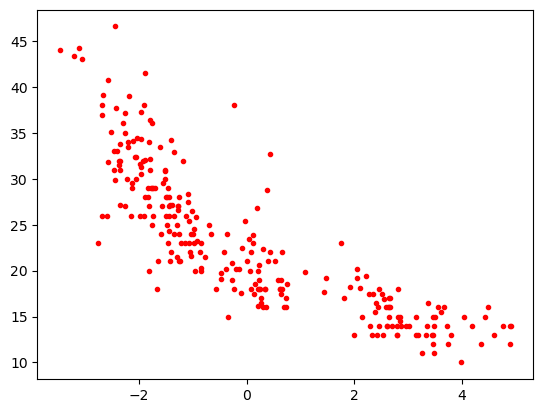

In [55]:
f, a = plt.subplots()
a.plot(X_transformed[:, 0], y_new, 'r.');

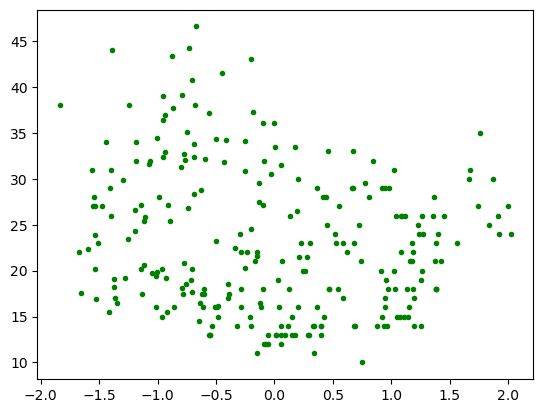

In [56]:
f, a = plt.subplots()
a.plot(X_transformed[:, 1], y_new, 'g.');

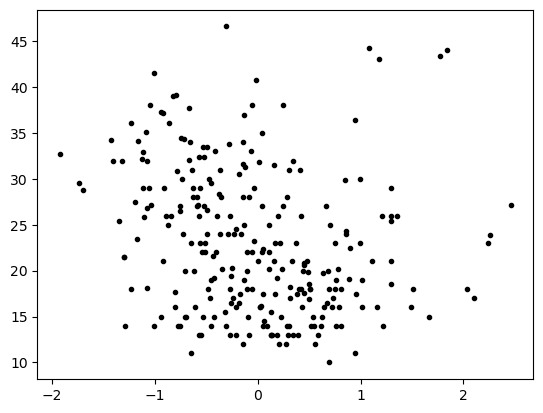

In [57]:
f, a = plt.subplots()
a.plot(X_transformed[:, 2], y_new, 'k.');

In [58]:
df = pd.DataFrame(np.hstack([X_transformed, y_new[:, np.newaxis]]),
                  columns=['PC1', 'PC2', 'PC3', 'y'])
df.head()

,PC1,PC2,PC3,y
0,-1.964657,-0.799510,-0.120081,31.3
1,-2.697423,1.117819,1.210028,26.0
2,-1.521356,1.870060,-0.475974,30.0
3,4.196965,1.192402,-1.005452,14.0
4,2.851495,0.150932,0.227496,15.0


/Users/nicholastjandra/anaconda3/envs/learn-env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


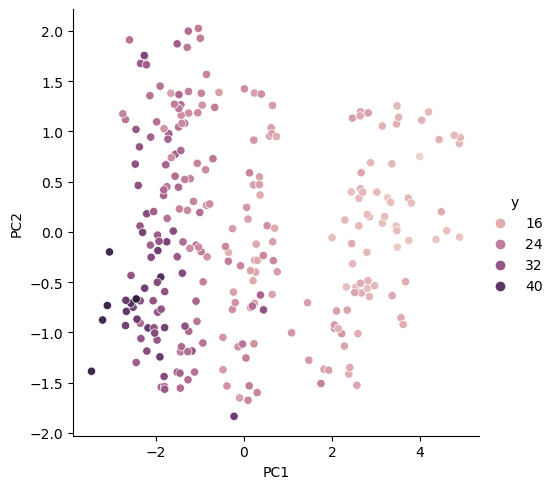

In [59]:
sns.relplot(data=df,
            x='PC1',
            y='PC2',
           hue='y');

## Level Up: Relation to Linear Regression

Question: Is the first principal component the same line we would get if we constructed an ordinary least-squares regression line?

Answer: No. The best-fit line minimizes the sum of squared errors, i.e. the minimum sum of ("vertical") distances between the predictions and the real values of the dependent variable. Principal Component Analysis, by contrast, is not a modeling procedure and so has no target. The first principal component thus cannot minimize the sum of distances between predictions and real values; instead, it minimizes the sum of ("perpendicular") distances between the data points and *it (the line) itself*.

Suppose we look at MPG vs. z-scores of weight in lbs. Let's make a scatter plot:

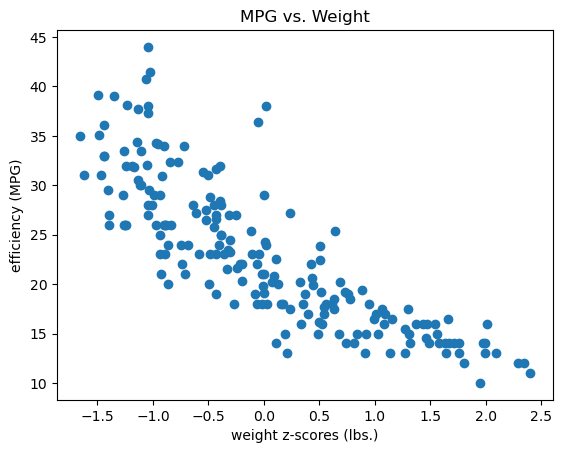

In [60]:
f, a = plt.subplots()

a.scatter(X_tr_pp[:, 1], y_train)
a.set_xlabel('weight z-scores (lbs.)')
a.set_ylabel('efficiency (MPG)')
a.set_title('MPG vs. Weight');

Let's add the best-fit line:

In [61]:
beta1 = LinearRegression().fit(X_tr_pp[:, 1].reshape(-1, 1),
                               y_train).coef_
beta0 = LinearRegression().fit(X_tr_pp[:, 1].reshape(-1, 1),
                               y_train).intercept_

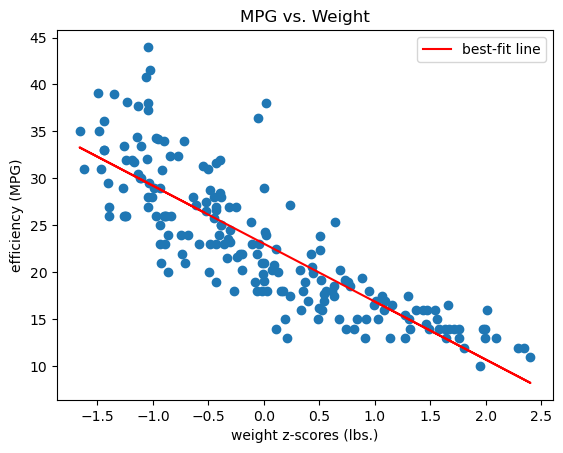

In [62]:
f, a = plt.subplots()

a.scatter(X_tr_pp[:, 1], y_train)
a.plot(X_tr_pp[:, 1],
       beta1[0] * X_tr_pp[:, 1] + beta0,
      c='r', label='best-fit line')
a.set_xlabel('weight z-scores (lbs.)')
a.set_ylabel('efficiency (MPG)')
a.set_title('MPG vs. Weight')
plt.legend();

Now let's see what the principal component looks like. We'll make use of the `inverse_transform()` method of `PCA()` objects.

In [63]:
pc1 = PCA(n_components=1).fit(np.concatenate((X_tr_pp[:, 1].reshape(-1, 1),
                                 y_train.values.reshape(-1, 1)),
                                axis=1))

pc = pc1.transform(np.concatenate((X_tr_pp[:, 1].reshape(-1, 1),
                                 y_train.values.reshape(-1, 1)),
                                axis=1))

pc_inv = pc1.inverse_transform(pc)

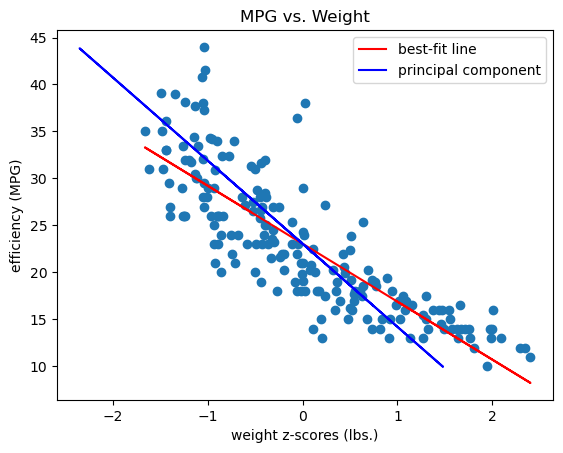

In [64]:
f, a = plt.subplots()

a.scatter(X_tr_pp[:, 1], y_train)
a.plot(X_tr_pp[:, 1],
       beta1[0] * X_tr_pp[:, 1] + beta0,
      c='r', label='best-fit line')
a.plot(pc_inv[:, 0],
       pc_inv[:, 1],
      c='b', label='principal component')
a.set_xlabel('weight z-scores (lbs.)')
a.set_ylabel('efficiency (MPG)')
a.set_title('MPG vs. Weight')
plt.legend();

Check out this post, to which the preceding is indebted, for more on this subtle point: https://shankarmsy.github.io/posts/pca-vs-lr.html

## Level Up: Diagonalization

The key idea is to diagonalize (i.e. find the eigendecomposition of) the covariance matrix. The decomposition will produce a set of orthogonal vectors that explain as much of the remaining variance as possible. These are our [principal components](https://math.stackexchange.com/questions/23596/why-is-the-eigenvector-of-a-covariance-matrix-equal-to-a-principal-component).

Let's say a word about eigenvalues and eigenvectors. It turns out that eigenvalues and -vectors have a dizzying number of applications. But the basic idea is that, if we can split a bunch of vectors (i.e. a matrix) into a set of mutually orthogonal vectors, then we can isolate the force of the bunch into discrete bits, each of which by itself acts like a simple linear transformation.

That is, the vector is oriented in just such a direction that multiplying the matrix by it serves only to lengthen or shorten it.

The diagonalization looks like this:

$A = Q\Lambda Q^{-1}$, where $Q$ is a matrix comprising the **eigenvectors** of $A$ and $\Lambda$ has non-zero elements only along its main diagonal (hence the "diagonalization" of $A$). These non-zero elements are the **eigenvalues** of $A$. We'll return to eigendecomposition later when we discuss recommendation systems and the singular value decomposition, which is a related matrix factorization.

Suppose we have the matrix
$A =
\begin{bmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22} \\
\end{bmatrix}
$.

Let's calculate the eigendecomposition of this matrix.

In order to do this, we set $(A - \lambda I)\vec{x} = 0$. One trivial solution is $\vec{x} = \vec{0}$, but if there are more interesting solutions, then it must be that $|A - \lambda I| = 0$, which is to say that some column vector in $A - \lambda I$ must be expressible as a linear combination of the other columns. (Otherwise, there would be no way to "undo" the multiplicative effect of a column vector on $\vec{x}$!) For more on this point, see [this page](http://www2.math.uconn.edu/~troby/math2210f16/LT/sec1_7.pdf).

So we have:

$\begin{vmatrix}
a_{11} - \lambda & a_{12} \\
a_{21} & a_{22} - \lambda
\end{vmatrix} = 0$

$(a_{11} - \lambda)(a_{22} - \lambda) - a_{12}a_{21} = 0$

$\lambda^2 - (a_{11} + a_{22})\lambda + a_{11}a_{22} - a_{12}a_{21}$

$\lambda = \frac{a_{11} + a_{22}\pm\sqrt{(a_{11} + a_{22})^2 + 4(a_{12}a_{21} - a_{11}a_{22})}}{2}$

Suppose e.g. we had

$A = \begin{bmatrix}
5 & 3 \\
3 & 5
\end{bmatrix}$.

We can use the equation we just derived to solve for the eigenvalues of this matrix. Then we can plug *those* into our eigenvector definition to solve for the eigenvectors

### Eigenvalues

$\lambda = \frac{5+5\pm\sqrt{(5+5)^2+4(3\times 3 - 5\times 5)}}{2} = 5\pm\frac{\sqrt{36}}{2} = 2, 8$.

### Eigenvectors

Now we can plug those in. If we plug in $\lambda = 8$, then we get:

$\begin{bmatrix}
5-8 & 3 \\
3 & 5-8
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
=
\begin{bmatrix}
-3 & 3 \\
3 & -3
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix} = 0.$

So:

$-3x_1 + 3x_2 = 0$ (or $3x_1 - 3x_2 = 0$)

$x_1 = x_2$.

It is standard to scale eigenvectors to a magnitude of 1, and so we would write this eigenvector as
$\begin{bmatrix}
\frac{\sqrt{2}}{2} \\
\frac{\sqrt{2}}{2}
\end{bmatrix}$.

If we plug in $\lambda = 2$, we find a second eigenvector equal to
$\begin{bmatrix}
-\frac{\sqrt{2}}{2} \\
\frac{\sqrt{2}}{2}
\end{bmatrix}$. (I'll leave this as an exercise.)

**Thus we can express the full diagonalization of our matrix as follows**:

$A = \begin{bmatrix}
5 & 3 \\
3 & 5
\end{bmatrix} =
\begin{bmatrix}
\frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2} \\
\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2}
\end{bmatrix}
\begin{bmatrix}
8 & 0 \\
0 & 2
\end{bmatrix}
\begin{bmatrix}
\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} \\
-\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2}
\end{bmatrix}$

### Level Up: Diagonalization In Code

In [65]:
# We can use np.linalg.eig()

A = np.array([[5, 3], [3, 5]])
np.linalg.eig(A)

(array([8., 2.]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

In [66]:
# np.linalg.eig(X) returns a double of NumPy arrays, the first containing
# the eigenvalues of X and the second containing the eigenvectors of X.

v, q = np.linalg.eig(A)

In [67]:
v

array([8., 2.])

In [68]:
# np.diag()

np.diag(v)

array([[8., 0.],
       [0., 2.]])

In [69]:
# Reconstruct A by multiplication

q.dot(np.diag(v)).dot(q.T)

array([[5., 3.],
       [3., 5.]])

In [70]:
# Illustration that the columns of q
# are eigenvectors of A, where
# multiplication by A scales them by
# the eigenvalues

print(np.allclose(A.dot(q.T[0]), v[0]*q.T[0]))
print(np.allclose(A.dot(q.T[1]), v[1]*q.T[1]))

True
True


## Extra Resource

[Here's](https://www.youtube.com/watch?v=_UVHneBUBW0) a helpful video introduction to PCA if you're itching for more!